In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, ColorJitter
import torch.optim as optim


In [2]:

# Set random seed for reproducibility
torch.manual_seed(42)


In [3]:
# Part I: Data Augmentation
# Exercise 1: Implement Basic Data Augmentation
def add_gaussian_noise(image, mean=0., std=0.02):  
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0., 1.)

# Define the normalization parameters for CIFAR-10
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2470, 0.2435, 0.2616)

# Define basic transformations with proper normalization
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

# Define augmented transformations with better parameters and order
augmented_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    ColorJitter(
        brightness=0.1,  
        contrast=0.1,   
        saturation=0.1  
    ),
    transforms.Lambda(add_gaussian_noise),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)  
])


In [4]:

# Load CIFAR-10 dataset
trainset_basic = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=basic_transform)


Files already downloaded and verified


In [5]:

trainset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=augmented_transform)


Files already downloaded and verified


In [6]:

# Visualization function
def show_images(original_images, augmented_images, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    
    for i in range(num_images):
        # Show original images
        axes[0, i].imshow(original_images[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        
        # Show augmented images
        axes[1, i].imshow(augmented_images[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        axes[1, i].set_title('Augmented')
    
    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.0942786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9100897..2.100835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.927342..1.9493101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6581874..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8500937..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7709224.

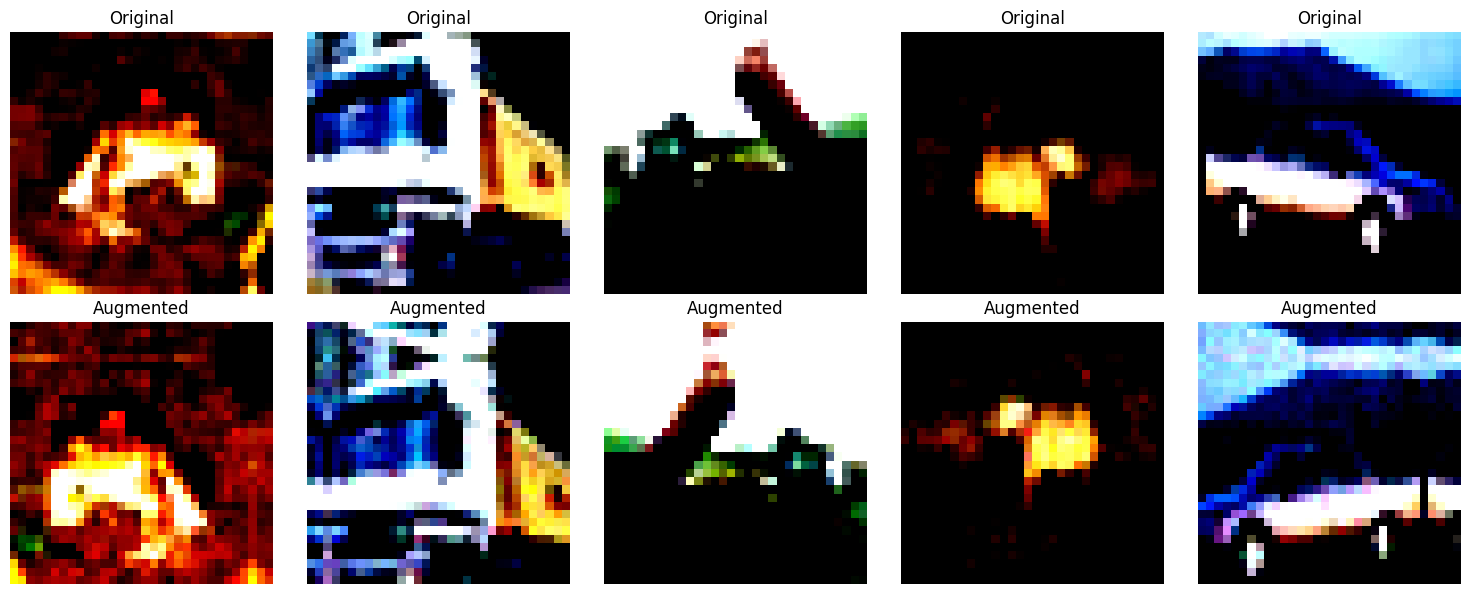

In [7]:

# Get some random training images
dataiter_basic = iter(torch.utils.data.DataLoader(trainset_basic, batch_size=5))
dataiter_augmented = iter(torch.utils.data.DataLoader(trainset_augmented, batch_size=5))

images_basic, _ = next(dataiter_basic)
images_augmented, _ = next(dataiter_augmented)

# Show images
show_images(images_basic, images_augmented)


In [8]:
# Exercise 2: Evaluate Impact of Data Augmentation
# Define CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [9]:
def train_model(model, trainloader, criterion, optimizer, device, epochs=5):
    model.train()
    running_loss = 0.0
    
    for epoch in range(epochs):
        for i, data in enumerate(trainloader):
            # Get the inputs and labels and move them to the device
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # Print every 200 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
                running_loss = 0.0

In [10]:

# Evaluation function
def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [11]:

# Setup for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device  = torch.device("mps" if torch.mps.is_available() else device)
print(device)


mps


In [12]:

batch_size = 32


In [13]:

# Dataloaders
trainloader_basic = torch.utils.data.DataLoader(trainset_basic, batch_size=batch_size,
                                              shuffle=True, num_workers=2, drop_last=True)

trainloader_augmented = torch.utils.data.DataLoader(trainset_augmented, batch_size=batch_size,
                                                  shuffle=True, num_workers=0, drop_last=True)


In [14]:

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=basic_transform)


Files already downloaded and verified


In [15]:

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                      shuffle=False, num_workers=2, drop_last=True)


In [16]:

# Train and evaluate models
models = {
    'augmented': SimpleCNN().to(device),
    'basic': SimpleCNN().to(device)
}


In [17]:

criterion = nn.CrossEntropyLoss()
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name} model...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    if model_name == 'basic':
        train_model(model, trainloader_basic, criterion, optimizer, device)
    else:
        train_model(model, trainloader_augmented, criterion, optimizer, device)
    
    accuracy = evaluate_model(model, testloader, device)
    results[model_name] = accuracy
    print(f'{model_name.capitalize()} Model Test Accuracy: {accuracy:.2f}%')



Training augmented model...
[1,   200] loss: 1.981
[1,   400] loss: 1.713
[1,   600] loss: 1.566
[1,   800] loss: 1.504
[1,  1000] loss: 1.417
[1,  1200] loss: 1.365
[1,  1400] loss: 1.317
[2,   200] loss: 2.258
[2,   400] loss: 1.198
[2,   600] loss: 1.177
[2,   800] loss: 1.176
[2,  1000] loss: 1.132
[2,  1200] loss: 1.123
[2,  1400] loss: 1.102
[3,   200] loss: 1.970
[3,   400] loss: 1.074
[3,   600] loss: 1.045
[3,   800] loss: 1.042
[3,  1000] loss: 1.018
[3,  1200] loss: 1.029
[3,  1400] loss: 1.014
[4,   200] loss: 1.815
[4,   400] loss: 0.965
[4,   600] loss: 0.953
[4,   800] loss: 0.960
[4,  1000] loss: 0.944
[4,  1200] loss: 0.941
[4,  1400] loss: 0.978
[5,   200] loss: 1.675
[5,   400] loss: 0.914
[5,   600] loss: 0.924
[5,   800] loss: 0.927
[5,  1000] loss: 0.911
[5,  1200] loss: 0.898
[5,  1400] loss: 0.929
Augmented Model Test Accuracy: 72.09%

Training basic model...
[1,   200] loss: 1.920
[1,   400] loss: 1.582
[1,   600] loss: 1.428
[1,   800] loss: 1.339
[1,  1000] 

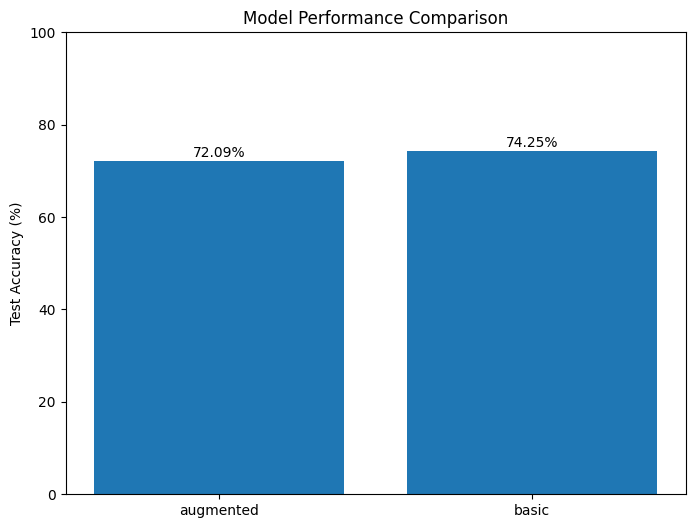

In [18]:

# Plot results
plt.figure(figsize=(8, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Performance Comparison')
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(results.values()):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center')
plt.show()